In [1]:
import warnings
from copy import deepcopy

from functools import partial
from multiprocessing import Pool, cpu_count
import os.path as op

import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np

from scipy.io import loadmat
from scipy.stats import ttest_ind, ttest_rel, pearsonr

from neurodsp.spectral import compute_spectrum
from neurodsp.utils.norm import normalize_sig
from neurodsp.filt import filter_signal

from fooof import FOOOF
from fooof.objs import combine_fooofs

from timescales.fit import convert_knee_val, fit_psd
from timescales.sim import sim_spikes_synaptic
from timescales.autoreg import compute_ar_spectrum
from timescales.plts import plot_connected_scatter
from timescales.utils import create_windows

from tqdm.notebook import tqdm

In [2]:
SMALL_SIZE = 12
MEDIUM_SIZE = 18
LARGE_SIZE = 24

plt.rc('lines', linewidth=2)

plt.rc('font', size=SMALL_SIZE, family='sans-serif')
plt.rc('axes', titlesize=SMALL_SIZE)
plt.rc('axes', labelsize=MEDIUM_SIZE)
plt.rc('xtick', labelsize=SMALL_SIZE)
plt.rc('ytick', labelsize=SMALL_SIZE)
plt.rc('legend', fontsize=MEDIUM_SIZE)
plt.rc('axes', titlesize=LARGE_SIZE)

plt.rc('ytick.major', size=5)
plt.rc('ytick.minor', size=2.5)
plt.rc('xtick.major', size=5)
plt.rc('xtick.minor', size=2.5)

sns.set_palette('colorblind')

### Spike Timescales
The timescales, as knee frequencies, are compared between 4 types:

- Wake : Excitatory Units
- NREM : Excitatory Units
- Wake : Inhibitory Units
- NREM : Inhibitory Units

### Spikes vs LFP

This then timescales are compared between spikes and LFPs.

In [3]:
def compute_spectra_trials(spikes_e, spikes_i, start_end, f_range, bin_size, ar_order,
                           kwargs_welch=None, kwargs_ar=None, mean=None, variance=None):
    """Compute Welch's and AR PSD for exciatatory and inhibitory spikes."""
    
    # Ensure unpackable
    if kwargs_welch is None:
        kwargs_welch = {}
    if kwargs_ar is None:
        kwargs_ar = {}
            
    # Compute AR-PSD and Welch's-PSD for each window
    for ind, (s, e) in enumerate(start_end):

        # Normalize
        spikes_bin_e = normalize_sig(
            spikes_e[s:e].reshape(-1, bin_size).sum(axis=1), 0, 1)
        
        spikes_bin_i = normalize_sig(
            spikes_i[s:e].reshape(-1, bin_size).sum(axis=1), 0, 1)
        
        # Compute excitatory spectra
        freqs_ar, _powers_ar_e = compute_ar_spectrum(spikes_bin_e, fs/bin_size, ar_order,
                                                     f_range=f_range, **kwargs_ar)
        
        freqs_welch, _powers_welch_e = compute_spectrum(spikes_bin_e, fs/bin_size,
                                                        f_range=f_range, **kwargs_welch)
        
        # Compute inhibitory spectra
        _, _powers_ar_i = compute_ar_spectrum(spikes_bin_i, fs/bin_size, ar_order,
                                              f_range=f_range, **kwargs_ar)
        
        _, _powers_welch_i = compute_spectrum(spikes_bin_i, fs/bin_size,
                                              f_range=f_range, **kwargs_welch)
        
        # Initalize arrays
        if ind == 0:
            
            freqs = {'welch': freqs_welch, 'ar': freqs_ar}
            
            powers = {
                'ar': {'excitatory': np.zeros((len(start_end), len(_powers_ar_e))),
                       'inhibitory': np.zeros((len(start_end), len(_powers_ar_i)))},
                'welch': {'excitatory': np.zeros((len(start_end), len(_powers_welch_e))),
                          'inhibitory': np.zeros((len(start_end), len(_powers_welch_i)))}
            }
            
        if mean is not None and variance is not None:
            _powers_ar_e = normalize_sig(_powers_ar_e, mean, variance)
            _powers_welch_e = normalize_sig(_powers_welch_e, mean, variance)
            _powers_ar_i = normalize_sig(_powers_ar_i, mean, variance)
            _powers_welch_i = normalize_sig(_powers_welch_i, mean, variance)
        
        powers['ar']['excitatory'][ind] = _powers_ar_e
        powers['welch']['excitatory'][ind] = _powers_welch_e
        powers['ar']['inhibitory'][ind] = _powers_ar_i
        powers['welch']['inhibitory'][ind] = _powers_welch_i
        
    return freqs, powers

In [4]:
# Load data
base_name = '20140526_277um'
dir_path = f'/home/rph/Projects/timescale-methods/fcx1/{base_name}'

subtype_dict = loadmat(f'{dir_path}/{base_name}_SSubtypes.mat')
subtype_e = subtype_dict['Se_CellFormat'][0]
subtype_i = subtype_dict['Si_CellFormat'][0]

fs = 20000

n_seconds = np.ceil(max([*[np.max(i) for i in subtype_i], 
                         *[np.max(i) for i in subtype_e]]))

times = np.arange(0, n_seconds, 1/fs)

# Extract behavioral data
beh_file = f'{dir_path}/{base_name}_WSRestrictedIntervals.mat'
beh = loadmat(beh_file)

nrem = beh['SWSPacketTimePairFormat'].astype(int) * fs
wake = beh['WakeTimePairFormat'].astype(int) *  fs

# Window by trial type
win_len = int(5*fs)
win_spacing = int(5*fs)

wake_starts, wake_mids, wake_ends = create_windows(wake, win_len, win_spacing)
nrem_starts, nrem_mids, nrem_ends = create_windows(nrem, win_len, win_spacing)

start_end_wake = np.vstack((wake_starts, wake_ends)).T
start_end_nrem = np.vstack((nrem_starts, nrem_ends)).T

### Computing the AR-PSD

The AR spectra are influences by the bin size and the AR order parameters. These parameters will influence the resulting timescales measurements. These spectra follow a Lorentzian form.

In [5]:
# Sum spikes across E/I sub-units
spikes_e = np.zeros(int(n_seconds * fs))
for s in subtype_e:
    
    st = s[:, 0] * fs
    st = st[np.where(st <= len(spikes_e))[0]]

    spikes_e[st.astype(int)] = 1
         
spikes_i = np.zeros(int(n_seconds * fs))
for s in subtype_i:
    
    st = s[:, 0] * fs
    st = st[np.where(st <= len(spikes_i))[0]]

    spikes_i[st.astype(int)] = 1
    
# Compute Spectra
f_range = (0, 100)
bin_size = 200
ar_order = 5

kwargs_welch = {'nperseg': 2*fs/bin_size}

freqs_wake, powers_wake = compute_spectra_trials(
    spikes_e, spikes_i, start_end_wake, f_range, bin_size, ar_order, kwargs_welch=kwargs_welch)

freqs_nrem, powers_nrem = compute_spectra_trials(
    spikes_e, spikes_i, start_end_nrem, f_range, bin_size, ar_order, kwargs_welch=kwargs_welch)

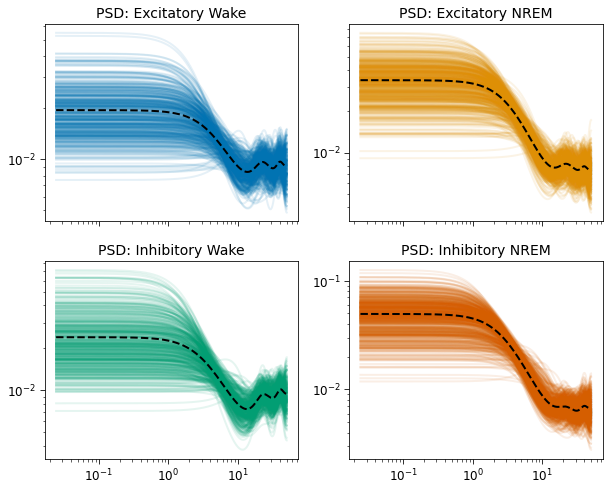

In [7]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 8), sharex=True)

# Excitatory
for p in powers_wake['ar']['excitatory'][:, 1:]:
    axes[0][0].loglog(freqs_wake['ar'][1:], p, color='C0', alpha=.1)
    
axes[0][0].loglog(freqs_wake['ar'][1:],
                  powers_wake['ar']['excitatory'][:, 1:].mean(axis=0),
                  color='k', ls='--')
    
for p in powers_nrem['ar']['excitatory'][:, 1:]:
    axes[0][1].loglog(freqs_nrem['ar'][1:], p, color='C1', alpha=.1)
    
axes[0][1].loglog(freqs_nrem['ar'][1:],
                  powers_nrem['ar']['excitatory'][:, 1:].mean(axis=0),
                  color='k', ls='--')

# Inhibitory
for p in powers_wake['ar']['inhibitory'][:, 1:]:
    axes[1][0].loglog(freqs_wake['ar'][1:], p, color='C2', alpha=.1)
    
axes[1][0].loglog(freqs_wake['ar'][1:],
                  powers_wake['ar']['inhibitory'][:, 1:].mean(axis=0),
                  color='k', ls='--')

for p in powers_nrem['ar']['inhibitory'][:, 1:]:
    axes[1][1].loglog(freqs_nrem['ar'][1:], p, color='C3', alpha=.1)
    
axes[1][1].loglog(freqs_nrem['ar'][1:],
                  powers_nrem['ar']['inhibitory'][:, 1:].mean(axis=0),
                  color='k', ls='--')

# Labels
axes[0][0].set_title('PSD: Excitatory Wake', size=14)
axes[0][1].set_title('PSD: Excitatory NREM', size=14)
axes[1][0].set_title('PSD: Inhibitory Wake', size=14)
axes[1][1].set_title('PSD: Inhibitory NREM', size=14);

### Fitting Spectra

In [8]:
# Fit FOOOF
fooof_init = {
    'aperiodic_mode': 'knee_constant', # allows tapering shown in the plot above
    'max_n_peaks': 4,
    'peak_threshold': 2.5
}

ap_bounds = [
    [-2, 1e-3, 1e-3, 1e-3],
    [ 4, 20,   10,  1e-1]
]

ap_guess = [-1, 1, 1, 1, 1e-2]

with warnings.catch_warnings():

    warnings.simplefilter("ignore")

    fm_ar_ex_nrem, k_ar_ex_nrem = fit_psd(freqs_nrem['ar'], powers_nrem['ar']['excitatory'],
                                          f_range, progress='tqdm.notebook', fooof_init=fooof_init,
                                          ap_bounds=ap_bounds, ap_guess=ap_guess)

    fm_ar_in_nrem, k_ar_in_nrem = fit_psd(freqs_nrem['ar'], powers_nrem['ar']['inhibitory'],
                                          f_range, progress='tqdm.notebook', fooof_init=fooof_init,
                                          ap_bounds=ap_bounds, ap_guess=ap_guess)
    
    fm_ar_ex_wake, k_ar_ex_wake = fit_psd(freqs_wake['ar'], powers_wake['ar']['excitatory'],
                                          f_range, progress='tqdm.notebook', fooof_init=fooof_init,
                                          ap_bounds=ap_bounds, ap_guess=ap_guess)

    fm_ar_in_wake, k_ar_in_wake = fit_psd(freqs_wake['ar'], powers_wake['ar']['inhibitory'],
                                          f_range, progress='tqdm.notebook', fooof_init=fooof_init,
                                          ap_bounds=ap_bounds, ap_guess=ap_guess);

Running FOOOFGroup:   0%|          | 0/562 [00:00<?, ?it/s]

Running FOOOFGroup:   0%|          | 0/562 [00:00<?, ?it/s]

Running FOOOFGroup:   0%|          | 0/429 [00:00<?, ?it/s]

Running FOOOFGroup:   0%|          | 0/429 [00:00<?, ?it/s]

### Comparing R-Squared

The NREM trials have a significantly higher r-squared values, compared to the wake trails. Comparing the timescales between the two may be confounded by this.

In [9]:
# Stats
rsq_ar_ex_wake = fm_ar_ex_wake.get_params('r_squared')
rsq_ar_in_wake = fm_ar_in_wake.get_params('r_squared')
rsq_ar_ex_nrem = fm_ar_ex_nrem.get_params('r_squared')
rsq_ar_in_nrem = fm_ar_in_nrem.get_params('r_squared')

print('Excitatory:')
print('Wake: ', 'mean=', rsq_ar_ex_wake.mean(), 'std=', rsq_ar_ex_wake.std())
print('NREM: ', 'mean=', rsq_ar_ex_nrem.mean(), 'std=', rsq_ar_ex_nrem.std())
print(ttest_ind(rsq_ar_ex_wake, rsq_ar_ex_nrem))
print()
print('Inhibitory:')
print('Wake: ', 'mean=', rsq_ar_in_wake.mean(), 'std=', rsq_ar_in_wake.std())
print('NREM: ', 'mean=', rsq_ar_in_nrem.mean(), 'std=', rsq_ar_in_nrem.std())
print(ttest_ind(rsq_ar_in_wake, rsq_ar_in_nrem))

Excitatory:
Wake:  mean= 0.8215759253365615 std= 0.2167119433765959
NREM:  mean= 0.9522372413911641 std= 0.06429946000153677
Ttest_indResult(statistic=-13.52049854441162, pvalue=2.4050810274766257e-38)

Inhibitory:
Wake:  mean= 0.7799027817818405 std= 0.2362667642304492
NREM:  mean= 0.9638841270974278 std= 0.051020109162062226
Ttest_indResult(statistic=-17.90296298553872, pvalue=2.641058978922996e-62)


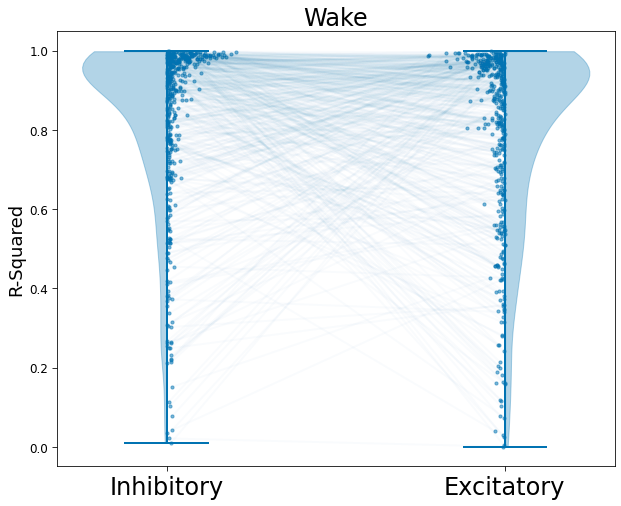

In [10]:
fig, ax = plt.subplots(figsize=(10, 8))

axes = plot_connected_scatter(rsq_ar_ex_wake, rsq_ar_in_wake, ax, violin_locs=[1, 2],
                              line_alpha=.025, scatter_jit=.1,
                              xticklabels=['Inhibitory', 'Excitatory'])

axes.set_ylabel('R-Squared')
axes.set_title('Wake');

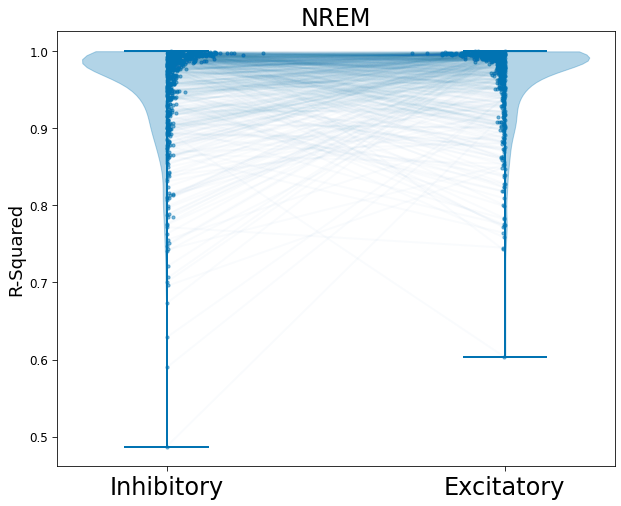

In [11]:
fig, ax = plt.subplots(figsize=(10, 8))

axes = plot_connected_scatter(rsq_ar_ex_nrem, rsq_ar_in_nrem, ax, violin_locs=[1, 2],
                              line_alpha=.025, scatter_jit=.1,
                              xticklabels=['Inhibitory', 'Excitatory'])

axes.set_ylabel('R-Squared')
axes.set_title('NREM');

### Comparing Timescales

The NREM trials have a significantly higher r-squared values, compared to the wake trails. Comparing the timescales between the two may be confounded by this. Only timescales with r-squared greater than 0.5 were compared.

There were significant differences (although not drastic) between the knee frequencies of the four groups:

```
Excitatory Wake mean= 5.605059832977624 std= 2.0899444673092535
Excitatory NREM mean= 4.572837642664896 std= 1.6634355204861524

Inhibitory Wake mean= 4.70422466209409  std= 1.7597496328338877
Inhibitory NREM mean= 4.01447632734246  std= 1.669157448767187


Excitatory: Wake vs NREM : pvalue=1.3144996751757471e-16
Inhibitory: Wake vs NREM : pvalue=2.5182246910072723e-09

Wake: Inhibitory vs Excitatory : pvalue=3.2923699545046245e-10
NREM: Inhibitory vs Excitatory : pvalue=2.553061437154798e-08
```

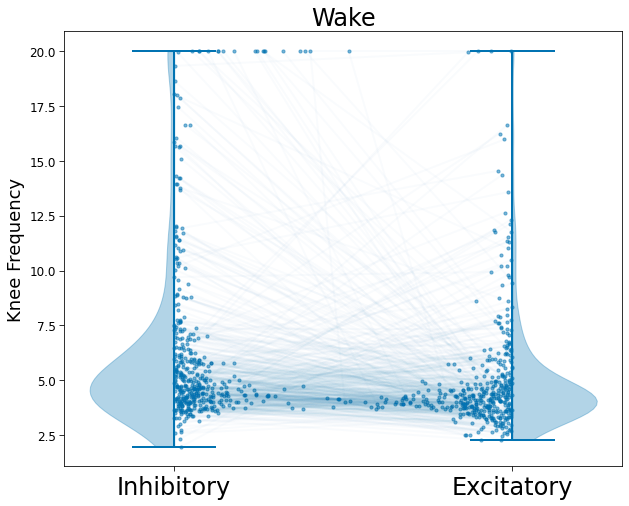

In [12]:
fig, ax = plt.subplots(figsize=(10, 8))

axes = plot_connected_scatter(k_ar_ex_wake, k_ar_in_wake, ax, violin_locs=[1, 2],
                              line_alpha=.025, scatter_jit=[.3, .3],
                              xticklabels=['Inhibitory', 'Excitatory'])

axes.set_ylabel('Knee Frequency')
axes.set_title('Wake');

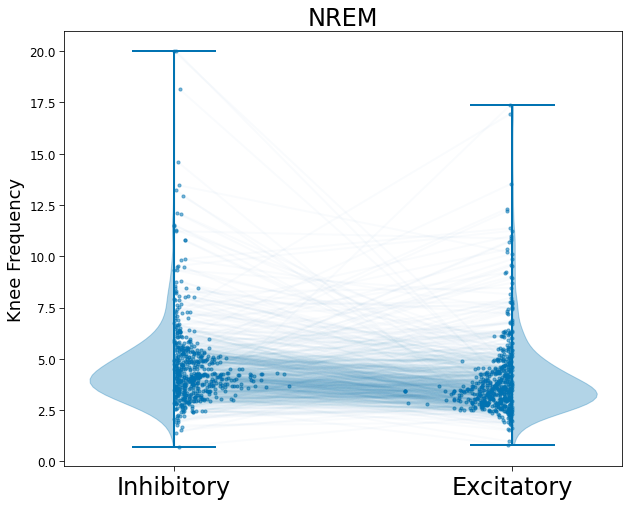

In [13]:
fig, ax = plt.subplots(figsize=(10, 8))

axes = plot_connected_scatter(k_ar_ex_nrem, k_ar_in_nrem, ax, violin_locs=[1, 2],
                              line_alpha=.025, scatter_jit=.15,
                              xticklabels=['Inhibitory', 'Excitatory'])

axes.set_ylabel('Knee Frequency')
axes.set_title('NREM');

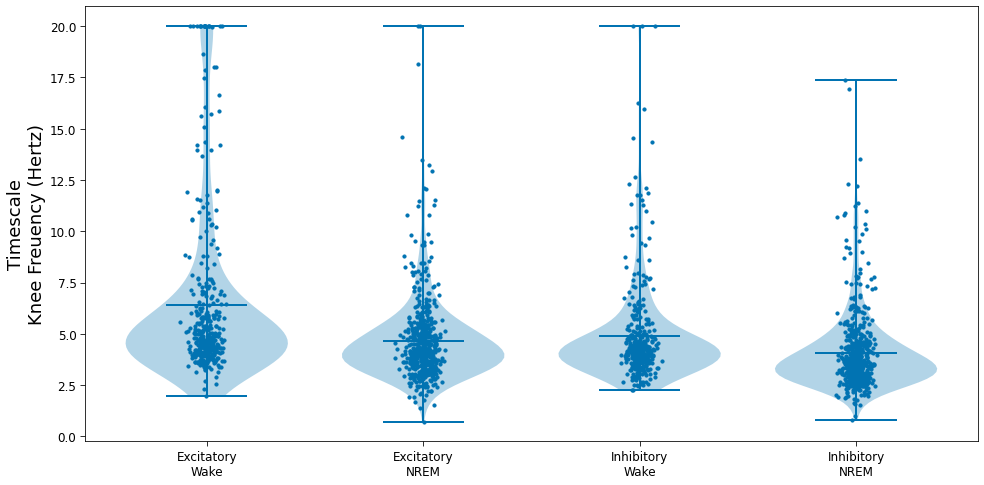

In [14]:
# Remove low r-squared fits
def filter_fits(rsqs, rsq_thresh):
    return np.where(rsqs >= rsq_thresh)[0]

rsq_thresh = 0.5
inds_ar_ex_wake = filter_fits(rsq_ar_ex_wake, rsq_thresh)
inds_ar_in_wake = filter_fits(rsq_ar_in_wake, rsq_thresh)
inds_ar_ex_nrem = filter_fits(rsq_ar_ex_nrem, rsq_thresh)
inds_ar_in_nrem = filter_fits(rsq_ar_in_nrem, rsq_thresh)

# Plot
plt.figure(figsize=(16, 8))

xlocs = np.linspace(1, 3, 4)

ds = [k_ar_ex_wake[inds_ar_ex_wake], k_ar_ex_nrem[inds_ar_ex_nrem], 
      k_ar_in_wake[inds_ar_in_wake], k_ar_in_nrem[inds_ar_in_nrem]]

plt.violinplot(ds, showmeans=True, positions=xlocs)

for dat, loc in zip(ds, xlocs):
    _xlocs = np.random.normal(loc, .025, len(dat))
    plt.scatter(_xlocs, dat, s=10, color='C0')

plt.ylabel('Timescale\nKnee Freuency (Hertz)')
plt.xticks(xlocs, labels=['Excitatory\nWake', 'Excitatory\nNREM',
                          'Inhibitory\nWake', 'Inhibitory\nNREM']);

In [15]:
print('Excitatory: Wake vs NREM')
print('Wake', 'mean=', ds[0].mean(), 'std=', ds[0].std())
print('NREM', 'mean=', ds[1].mean(), 'std=', ds[1].std())
print(ttest_ind(ds[0], ds[1]))
print()
print('Inhibitory: Wake vs NRM')
print('Wake', 'mean=', ds[2].mean(), 'std=', ds[2].std())
print('NREM', 'mean=', ds[3].mean(), 'std=', ds[3].std())
print(ttest_ind(ds[2], ds[3]))
print()
print('Wake: Inhibitory vs Excitatory')
print(ttest_ind(ds[0], ds[2]))
print()
print('NREM: Inhibitory vs Excitatory')
print(ttest_ind(ds[1], ds[3]))

Excitatory: Wake vs NREM
Wake mean= 6.409594715072436 std= 4.121208985961638
NREM mean= 4.673789228183016 std= 2.1088263719458427
Ttest_indResult(statistic=8.484542417204866, pvalue=8.272494127773512e-17)

Inhibitory: Wake vs NRM
Wake mean= 4.912171137370713 std= 2.5277376242104967
NREM mean= 4.066242433241119 std= 1.9071543228581433
Ttest_indResult(statistic=5.796379002450699, pvalue=9.280707044831033e-09)

Wake: Inhibitory vs Excitatory
Ttest_indResult(statistic=5.97395220979583, pvalue=3.5699879872169226e-09)

NREM: Inhibitory vs Excitatory
Ttest_indResult(statistic=5.058982938070548, pvalue=4.92171346057284e-07)


### Comparison to LFP

In [16]:
# Load LFP
data_id = '20140526_277um'
data_dir = f'/home/rph/Projects/timescale-methods/fcx1/data_mats/{data_id}'
fs = 1250

# Infer shape using one channel
lfp_file = op.join(data_dir, 'data01.mat')
sig_len = len(loadmat(lfp_file)['data'][0])

# Get PFC channels
channels = list(range(17, 49))
sig_lfp = np.zeros(sig_len)

for cind, ch in enumerate(channels):
    lfp_file = op.join(data_dir, f'data{ch}.mat')
    _sig_lfp = loadmat(lfp_file)['data'][0]
    sig_lfp += _sig_lfp
    
del _sig_lfp

sig_lfp = sig_lfp / len(channels)
sig_lfp =  normalize_sig(sig_lfp, 0, 1)

times = np.arange(0, len(sig_lfp)/fs, 1/fs)

# Windows
nrem = beh['SWSPacketTimePairFormat'].astype(int) * fs
wake = beh['WakeTimePairFormat'].astype(int) * fs

# Window by trial type
win_len = int(5*fs)
win_spacing = int(5*fs)

wake_starts, wake_mids, wake_ends = create_windows(wake, win_len, win_spacing)
nrem_starts, nrem_mids, nrem_ends = create_windows(nrem, win_len, win_spacing)

start_end_wake = np.vstack((wake_starts, wake_ends)).T
start_end_nrem = np.vstack((nrem_starts, nrem_ends)).T

In [17]:
def _fit_windows(start_end, sig=None):

    # Settings
    ar_order = 5
    f_range = (0, 100)
    fooof_init = {'max_n_peaks': 4, 'peak_threshold':2.5}
    
    start, end = start_end[0], start_end[1]
    sig_win = sig[start:end]
    
    freqs_ar, powers_ar = compute_ar_spectrum(sig_win, fs, ar_order)
    
    ap_bounds = [
        [-2, 1e-3, 1e-3],
        [ 4, 20,   10]
    ]

    ap_guess = [-1, 1, 1, 1]

    fm_ar, _ = fit_psd(freqs_ar, powers_ar, f_range, fooof_init, f_range, n_jobs=1)

    return fm_ar

In [18]:
with Pool(cpu_count()) as pool:
    
    mapping = pool.imap(partial(_fit_windows, sig=sig_lfp), start_end_wake)
    
    fm_ar_lfp_wake = list(tqdm(mapping, total=len(start_end_wake)))
    
with Pool(cpu_count()) as pool:
    
    mapping = pool.imap(partial(_fit_windows, sig=sig_lfp), start_end_nrem)
    
    fm_ar_lfp_nrem = list(tqdm(mapping, total=len(start_end_nrem)))

  0%|          | 0/429 [00:00<?, ?it/s]

  0%|          | 0/562 [00:00<?, ?it/s]

In [19]:
fg_ar_lfp_wake = combine_fooofs(fm_ar_lfp_wake)
fg_ar_lfp_nrem = combine_fooofs(fm_ar_lfp_nrem)

knees_wake_ar_lfp = fg_ar_lfp_wake.get_params('aperiodic', 'knee')
knees_nrem_ar_lfp = fg_ar_lfp_nrem.get_params('aperiodic', 'knee')

rsq_ar_lfp_nrem = fg_ar_lfp_nrem.get_params('r_squared')
rsq_ar_lfp_wake = fg_ar_lfp_wake.get_params('r_squared')

nrem_inds = np.where(
    (rsq_ar_lfp_nrem > .5) &
    (rsq_ar_ex_nrem > .5) &
    (rsq_ar_in_nrem > .5)
)[0]

wake_inds = np.where(
    (rsq_ar_lfp_wake > .5) &
    (rsq_ar_ex_wake > .5) &
    (rsq_ar_in_wake > .5)
)[0]

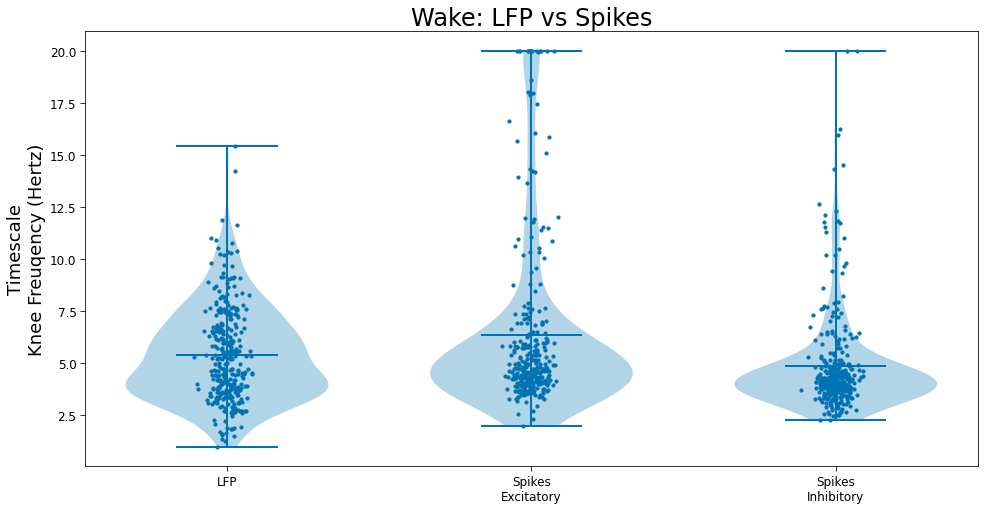

In [20]:
plt.figure(figsize=(16, 8))

ds = [knees_wake_ar_lfp[wake_inds], k_ar_ex_wake[wake_inds],
      k_ar_in_wake[wake_inds]]

xlocs = np.linspace(1, 2.5, 3)
                    
plt.violinplot(ds, showmeans=True, positions=xlocs)

for dat, loc in zip(ds, xlocs):
    _xlocs = np.random.normal(loc, .025, len(dat))
    plt.scatter(_xlocs, dat, s=10, color='C0')

plt.title('Wake: LFP vs Spikes')

plt.ylabel('Timescale\nKnee Freuqency (Hertz)')

plt.xticks(xlocs, labels=['LFP', 'Spikes\nExcitatory', 'Spikes\nInhibitory']);

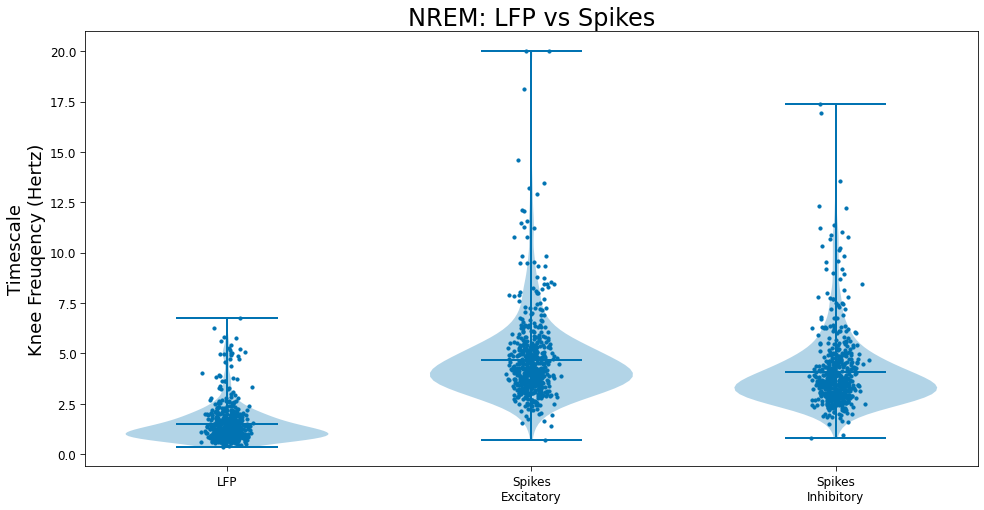

In [21]:
plt.figure(figsize=(16, 8))

ds = [knees_nrem_ar_lfp[nrem_inds], k_ar_ex_nrem[nrem_inds],
      k_ar_in_nrem[nrem_inds]]

xlocs = np.linspace(1, 2.5, 3)
                    
plt.violinplot(ds, showmeans=True, positions=xlocs)

for dat, loc in zip(ds, xlocs):
    _xlocs = np.random.normal(loc, .025, len(dat))
    plt.scatter(_xlocs, dat, s=10, color='C0')

plt.title('NREM: LFP vs Spikes')

plt.ylabel('Timescale\nKnee Freuqency (Hertz)')

plt.xticks(xlocs, labels=['LFP', 'Spikes\nExcitatory', 'Spikes\nInhibitory']);

In [22]:
print('Wake')
print(f'LFP               : mean={knees_wake_ar_lfp[wake_inds].mean()}, std={knees_wake_ar_lfp[wake_inds].std()}')
print(f'Spikes, Excitatory: mean={k_ar_ex_wake[wake_inds].mean()}, std={k_ar_ex_wake[wake_inds].std()}')
print(f'Spikes, Inhibitory: mean={k_ar_in_wake[wake_inds].mean()}, std={k_ar_in_wake[wake_inds].std()}')
print()
print(f'NREM')
print(f'LFP               : mean={knees_nrem_ar_lfp[nrem_inds].mean()}, std={knees_nrem_ar_lfp[nrem_inds].std()}')
print(f'Spikes, Excitatory: mean={k_ar_ex_nrem[nrem_inds].mean()}, std={k_ar_ex_nrem[nrem_inds].std()}')
print(f'Spikes, Inhibitory: mean={k_ar_in_nrem[nrem_inds].mean()}, std={k_ar_in_nrem[nrem_inds].std()}')

Wake
LFP               : mean=5.371863121940904, std=2.2536124508768727
Spikes, Excitatory: mean=6.363997375551424, std=4.198598518206156
Spikes, Inhibitory: mean=4.847543482591124, std=2.458113586429114

NREM
LFP               : mean=1.4899557708348041, std=0.9704939378607275
Spikes, Excitatory: mean=4.673789228183016, std=2.1088263719458427
Spikes, Inhibitory: mean=4.064769041959997, std=1.9085337474328592


In [23]:
print('Spikes')
print('Wake vs NREM:     ', ttest_ind(knees_wake_ar_lfp[wake_inds], knees_nrem_ar_lfp[nrem_inds]))
print()
print('Wake')
print('LFP vs Excitatory:', ttest_rel(knees_wake_ar_lfp[wake_inds], k_ar_ex_wake[wake_inds]))
print('LFP vs Inhibitory:', ttest_rel(knees_wake_ar_lfp[wake_inds], k_ar_in_wake[wake_inds]))
print()
print(f'NREM')
print('LFP vs Excitatory:', ttest_rel(knees_nrem_ar_lfp[nrem_inds], k_ar_ex_nrem[nrem_inds]))
print('LFP vs Inhibitory:', ttest_rel(knees_nrem_ar_lfp[nrem_inds], k_ar_in_nrem[nrem_inds]))

Spikes
Wake vs NREM:      Ttest_indResult(statistic=35.573269239021656, pvalue=2.9283622128562756e-173)

Wake
LFP vs Excitatory: Ttest_relResult(statistic=-3.5524527252328557, pvalue=0.0004368965649147672)
LFP vs Inhibitory: Ttest_relResult(statistic=2.7376687246608116, pvalue=0.006521110647650202)

NREM
LFP vs Excitatory: Ttest_relResult(statistic=-36.43345331293269, pvalue=7.156876977406037e-150)
LFP vs Inhibitory: Ttest_relResult(statistic=-39.07404420870041, pvalue=4.308699128732805e-162)


In [24]:
print('Correlation')

print('Wake: LFP vs Excitatory: r={:.4f}, p={:.4f}'.format(*pearsonr(knees_wake_ar_lfp[wake_inds],
                                                                     k_ar_ex_wake[wake_inds])))

print('Wake: LFP vs Inhibitory: r={:.4f}, p={:.4f}'.format(*pearsonr(knees_wake_ar_lfp[wake_inds],
                                                                     k_ar_in_wake[wake_inds])))
print()
print('NREM: LFP vs Excitatory: r={:.4f}, p={:.4f}'.format(*pearsonr(knees_nrem_ar_lfp[nrem_inds],
                                                                     k_ar_ex_nrem[nrem_inds])))

print('NREM: LFP vs Inhibitory: r={:.4f}, p={:.4f}'.format(*pearsonr(knees_nrem_ar_lfp[nrem_inds],
                                                                     k_ar_in_nrem[nrem_inds])))

Correlation
Wake: LFP vs Excitatory: r=-0.1685, p=0.0020
Wake: LFP vs Inhibitory: r=-0.0954, p=0.0822

NREM: LFP vs Excitatory: r=0.2718, p=0.0000
NREM: LFP vs Inhibitory: r=0.5811, p=0.0000


In [25]:
# Release memory
del fm_ar_lfp_nrem
del fm_ar_lfp_wake

In [233]:
knees = np.concatenate([
    knees_wake_ar_lfp[wake_inds],
    k_ar_ex_wake[wake_inds],
    k_ar_in_wake[wake_inds],
    knees_nrem_ar_lfp[nrem_inds],
    k_ar_ex_nrem[nrem_inds],
    k_ar_in_nrem[nrem_inds]
])

labels = [
    *['LFP : Wake'] * len(wake_inds),
    *['Spikes : Excitatory : Wake'] * len(wake_inds),
    *['Spikes : Inhibitory : Wake'] * len(wake_inds),
    *['LFP : NREM'] * len(nrem_inds),
    *['Spikes : Excitatory : NREM'] * len(nrem_inds),
    *['Spikes : Inhibitory : NREM'] * len(nrem_inds)
]

df = pd.DataFrame(dict(knees=knees, labels=labels))
df.to_csv('./pd_df.csv')

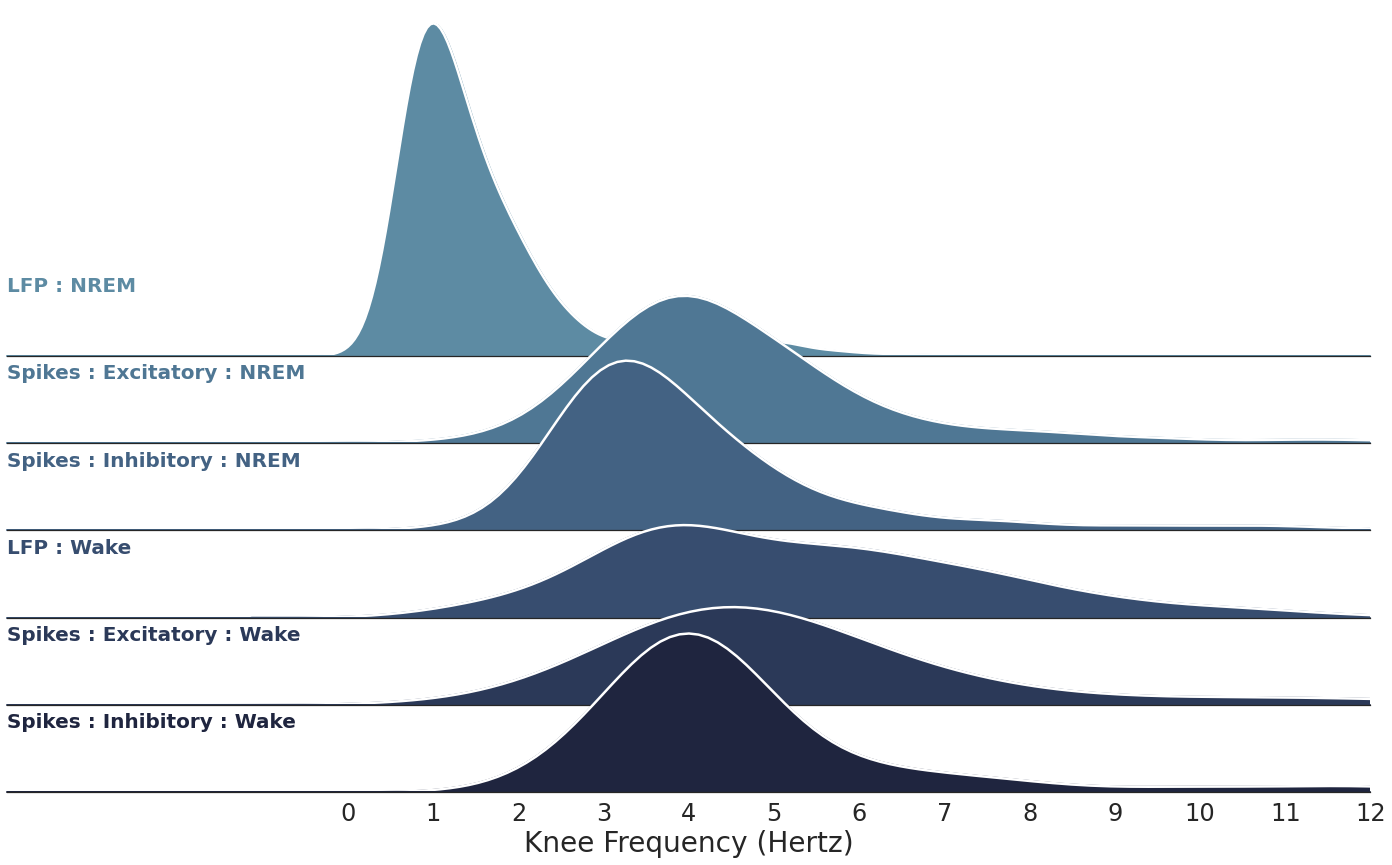

In [242]:

def plot_overlapping_densities(df, xlim, overlap_hspace=-.5):
    
    sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

    # Initialize the FacetGrid object
    pal = sns.cubehelix_palette(6, rot=-.25, light=.5)
    
    grid = sns.FacetGrid(df, row="labels", hue="labels", aspect=10,
                         height=2, palette=pal, xlim=xlim)

    # Draw the densities in a few steps
    grid.map(sns.kdeplot, "knees", clip_on=True,
             fill=True, alpha=1, linewidth=2)
   
    grid.map(sns.kdeplot, "knees", clip_on=True, color="w", lw=2.5, bw_adjust=1)

    grid.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)

    # Label the plot in axes coordinates
    def label(x, color, label):
        ax = plt.gca()
        ax.text(0, .2, label, fontweight="bold", color=color,
                ha="left", va="center", transform=ax.transAxes, size=20)

    grid.map(label, "knees")

    # Set the subplots to overlap
    grid.figure.subplots_adjust(hspace=overlap_hspace)

    # Remove axes details that don't play well with overlap
    grid.set_titles("")
    grid.set(yticks=[], ylabel="")
    grid.set(xticks=np.arange(0, xlim[1]+1))
    grid.despine(bottom=False, left=True)
    
    grid.set_xticklabels(np.arange(0, xlim[1]+1), size=24)
    grid.set_xlabels('Knee Frequency (Hertz)', size=28)
    
    return g

plot_overlapping_densities(df, (-4, 12), overlap_hspace=-0.75)
plt.savefig('overlapping_knee_densities.png', dpi=300, facecolor='w', bbox_inches="tight");